# Logic for Creating Movement of an Agent

Here we will be creating the logic for creating an agent.

The perception system of the agent can be defined as a 6 parameter vector
```
(tx,ty,tz,rx,ry,rz)
```
with translation and rotation of the agents reference system.

As is convention, we will be using the ROS coordinate system.

In [13]:
import os
from sys import path
path.append(os.getcwd()+"/..")
from logic.rayperception import RayPerception
import numpy as np
from logic.bbox_calculation import bbox_corners
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

We get the position of an object in global space

In [77]:
bbox_info = {"h" : 1, "w" : 2, "l" : 5, "x" : 10, "y" : 0, "z" : 0, "yaw" : np.pi/4}

In [78]:
bbox_c = bbox_corners(bbox_info)

In [79]:
def bbox2reference(bbox, reference):
    nbbox = bbox.copy()
    nbbox[:3] = Rotation.from_euler("xyz",reference[3:6], degrees=False).inv().apply(bbox[:3] - reference[:3])
    nbbox[3:6] -= reference[3:6]
    return nbbox

In [80]:
def array_from_dict(params: dict):
    h       = params.get("h", 0) 
    w       = params.get("w", 0) 
    l       = params.get("l", 0) 
    x       = params.get("x", 0) 
    y       = params.get("y", 0) 
    z       = params.get("z", 0) 
    roll    = params.get("roll", 0)
    pitch   = params.get("pitch", 0)
    yaw     = params.get("yaw", 0)
    return np.array([x,y,z,roll,pitch,yaw,l,w,h])

In [81]:
agent_view = bbox2reference(array_from_dict(bbox_info), array_from_dict({"z": 2.})[:6])
agent_view

array([10.        ,  0.        , -2.        ,  0.        ,  0.        ,
        0.78539816,  5.        ,  2.        ,  1.        ])

In [82]:
class AgentReference():
    def __init__(self, num_layers=1, num_points_per_layer=1, fov=np.pi, tilt=-np.pi/8) -> None:
        self.perception = RayPerception(num_layers=num_layers, num_points_per_layer=num_points_per_layer, fov=fov, tilt=tilt)
        self.position =  np.zeros(3)
        self.rotation =  np.zeros(3)

    def move(self, vector: np.ndarray):
        assert vector.shape == (3,), "Wrong input shape"
        self.position += vector

    def set_position(self, vector: np.ndarray):
        assert vector.shape == (3,), "Wrong input shape"
        self.position = vector.astype(np.float64)
    
    def rotate(self, vector: np.ndarray):
        assert vector.shape == (3,), "Wrong input shape"
        self.rotation += vector

    def set_rotation(self, vector: np.ndarray):
        assert vector.shape == (3,), "Wrong input shape"
        self.rotation = vector.astype(np.float64)
    
    def get_perception(self, object_list: list):
        '''
            transpose all objects in the list to the view of the agent
        '''
        bbox_list = list()
        reference_system = np.concatenate([self.position, self.rotation])
        for o in object_list:
            bbox_list.append(bbox2reference(array_from_dict(o), reference_system))
        
        return self.perception.get_lidar_points(bbox_list)

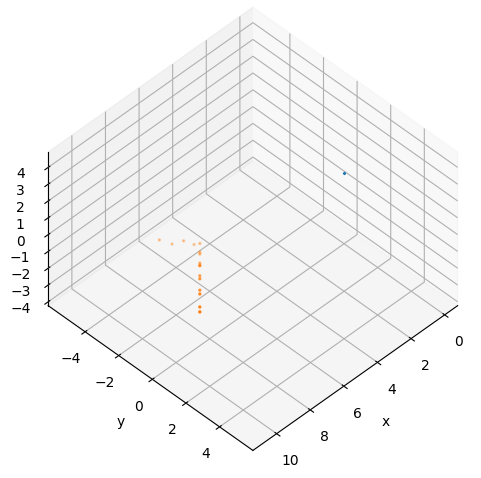

In [83]:
agent = AgentReference(num_layers=32, num_points_per_layer=100, fov=np.pi, tilt=-np.pi/8)
points = agent.get_perception([bbox_info])

ax = plt.axes(projection='3d')
ax.scatter3D(points[:,0], points[:,1], points[:,2], s=2)
ax.scatter3D(0, 0, 0, s=5, marker="x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()

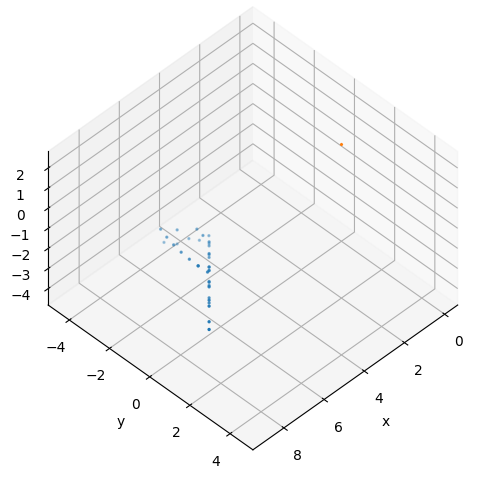

In [84]:
agent.move(np.array([2,0,2]))
points = agent.get_perception([bbox_info])

ax = plt.axes(projection='3d')
ax.scatter3D(points[:,0], points[:,1], points[:,2], s=2)
ax.scatter3D(0, 0, 0, s=5, marker="x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()

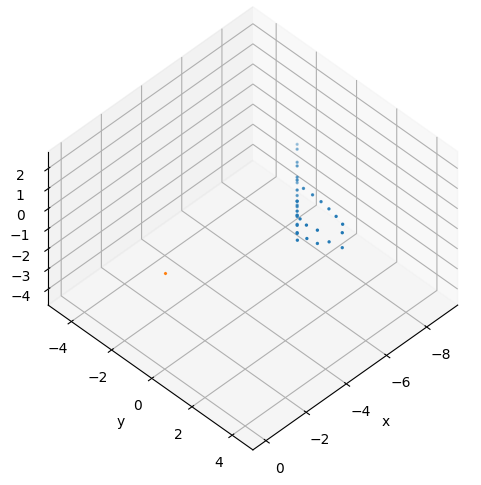

In [85]:
agent.rotate(np.array([0,0,np.pi]))
points = agent.get_perception([bbox_info])

ax = plt.axes(projection='3d')
ax.scatter3D(points[:,0], points[:,1], points[:,2], s=2)
ax.scatter3D(0, 0, 0, s=5, marker="x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()

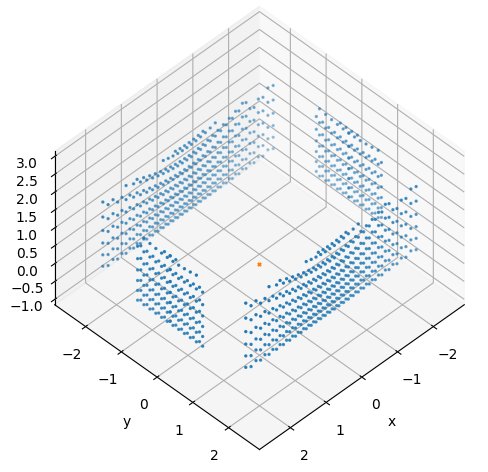

In [91]:
bbox_list = [
    {"h": 2., "w": 2., "l": 5., "x": 5.},
    {"h": 2., "w": 2., "l": 5., "x": -5.},
    {"h": 2., "w": 2., "l": 5., "y": 3.},
    {"h": 2., "w": 2., "l": 5., "y": -3.},
]
agent.set_position(np.array([0,0,0],dtype=np.float64))
agent.set_rotation(np.array([0,0,0],dtype=np.float64))
points = agent.get_perception(bbox_list)

ax = plt.axes(projection='3d')
ax.scatter3D(points[:,0], points[:,1], points[:,2], s=2)
ax.scatter3D(0, 0, 0, s=5, marker="x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()

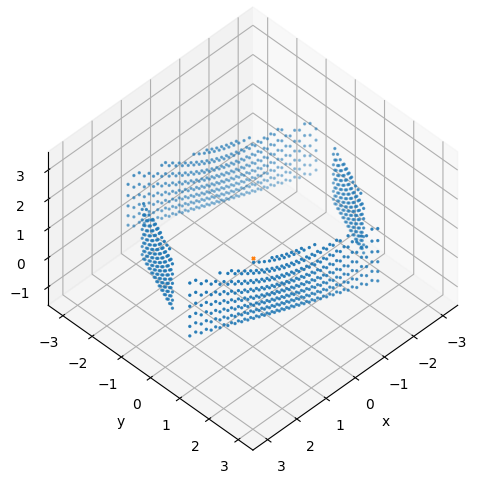

In [92]:
agent.rotate(np.array([0,0,np.pi/8.]))
points = agent.get_perception(bbox_info)

ax = plt.axes(projection='3d')
ax.scatter3D(points[:,0], points[:,1], points[:,2], s=2)
ax.scatter3D(0, 0, 0, s=5, marker="x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()

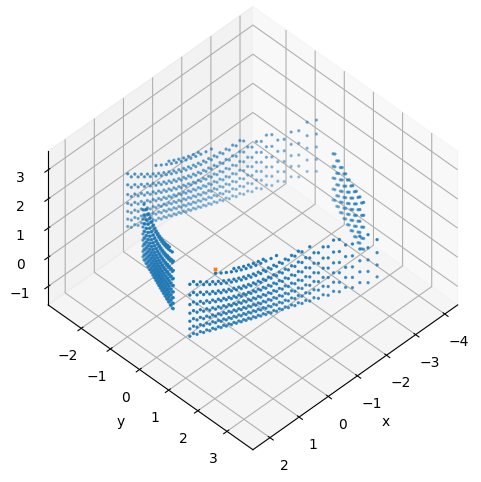

In [93]:
agent.move(np.array([1,0,0],dtype=float))
points = agent.get_perception(bbox_info)

ax = plt.axes(projection='3d')
ax.scatter3D(points[:,0], points[:,1], points[:,2], s=2)
ax.scatter3D(0, 0, 0, s=5, marker="x")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_proj_type('ortho')
ax.set_aspect('equal','box')
ax.view_init(45, 45, 0)
plt.tight_layout()